# Data cleaning and preparation

## Importing packages

In [630]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns

# set figure parameters to increase resolution
sc.settings.set_figure_params(dpi=100)

## Reading data
Paths presented in this notebook are specific for the computational system we were working in, please replace with your own paths for replication of data. The `filtered_feature_bc_matrix.h5` files are available in the Mendeley Data repository. We have renamed them with the names found in the `batches` variable, i.e. `day16_pool_1.sample_filtered_feature_bc_matrix.h5`.

In [ ]:
# batches to aggregate together
batchs = ['day16_pool_1','day16_pool_2','day16_pool_3','day8_pool1_1','day8_pool1_3','Preinfusion_day0_pool']
# experiments associated with each 10x reaction in the format <DAY-10XREACTION>
categories = ['D16-1','D16-2','D16-3','D8-1','D8-2','D0']
# directory where the 10x 
dn = '/fh/fast/greenberg_p/SR/ngs/illumina/ysu2/240105_A00613_0653_BHT7LVDMXY/cellranger/'
# tracking variable to store AnnData objects
adatas = []
# loop through each batch
for batch in batchs:
    # combine the directory and prefix/suffixes to derive the full path
    fn = dn + batch + '/outs/per_sample_outs/' + batch + '/count/sample_filtered_feature_bc_matrix.h5'
    # read in the 10x output via Scanpy
    adata = sc.read_10x_h5(fn, gex_only=False)
    # make all variable names unique
    adata.var_names_make_unique()
    # append to the running list of AnnData objects
    adatas.append(adata)
# fully concatenate the AnnData objects to each other with the batches labeled by their true experimental name
adata = adatas[0].concatenate(adatas[1:], batch_categories=categories)

## Hashtag demultiplexing
Multiple conditions were pooled together for financial efficacy and identified via hashtags. We utilize published algorithm Hashsolo to demultiplex our data and remove any doublets.

In [ ]:
# hashtags are assigned to the last ten variables
adata_hto = adata[:, -10:].copy()
# these experiments only utilized the first eight hashtags
# thus we only retrieve the UMI counts from these columns
htos = ['HTO01','HTO02','HTO03', 'HTO04', 'HTO05', 'HTO06', 'HTO07', 'HTO08']
adata_hto.obs[htos] = sc.get.obs_df(adata_hto, keys=htos)
# perform hashsolo based demultiplexing
sc.external.pp.hashsolo(adata_hto, cell_hashing_columns=htos)
# hashsolo output columns are copied back to the main AnnData object
outs = ['negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification']
adata_hto = adata_hto.obs[outs]
adata.obs[adata_hto.columns] = adata_hto

# samples relevant to this manuscript are identified by
# hashtags 5 and 9 single positive for day 0
# and as hashtags 1 and 5 for days 8 and 16
mask = ((adata.obs['batch'] == 'D0') & (adata.obs['Classification'].isin(['HTO09','HTO05']))) |\
((adata.obs['batch'] != 'D0') & (adata.obs['Classification'].isin(['HTO01','HTO05'])))
# raw counts are stored as both a Scanpy layer and in the .raw attribute
adata.layers['raw_counts'] = adata.X
adata.raw = adata
# the raw unfiltered data is stored separately, this is on Mendeley Data
# adata.write('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/h5ads/raw.control.h5ad')

## Quality control
Native Scanpy quality control, QC, functions are leveraged to derive `n_counts` (# of UMIs) and `n_genes` (# of unique genes expressed) metrics for each single cell. `perc_mito` (% of counts that are mitochondrial, a well-known metric of low-quality or dying cells) is calculated by deriving a `n_counts` only from mitochondrial genes (filtered as genes that begin with "MT-".

In [ ]:
# leverage native Scanpy functions to derive n-counts and n-genes
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=0)
# calculate % of mitochondrial reads
adata.obs['perc_mito'] = adata[:, adata.var.index.str.startswith('MT-')].X.sum(1).A1 / adata.obs['n_counts']
# visually inspect the QC metrics to determine cutoffs
sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.scatter(adata, x='n_counts', y='perc_mito')
# perform quality control based filtering
mask = (adata.obs['n_counts'] >= 1000) & (adata.obs['n_genes'] >= 500) & (adata.obs['perc_mito'] < 0.10)
mask = mask & (adata.obs['n_counts'] < 50000) & (adata.obs['n_genes'] < 8000)
adata = adata[mask, :].copy()

Although Hashsolo removed some multiplets, we want to ensure that doublets are as completely removed as possible. Therefore we also use published algorithm Scrublet, all of these previous works are cited in manuscript, to further clean up our data and filter for singlets only.

In [ ]:
import scrublet
# create Scrublet object
scrub = scrublet.Scrublet(adata.X)
# automatically call for doublets and determine cutoff
scores, mask = scrub.scrub_doublets()
# plot the histogram to manually verify cutoff
scrub.plot_histogram()
# attach the scrublet scores to the AnnData object
adata.obs['scrublet_score'] = scores
# hard-code a filter of 0.20, visually determined based on histogram
adata = adata[adata.obs['scrublet_score'] < 0.20].copy()

## Data normalization
We have custom aligned transcripts to gene bodies within our DNA barcode encoding plasmids as well. We retrieve these gene counts out and attach them as observations to our AnnData object such that we retain their information but that their counts, technical in nature, do not impact transcriptomic analyses. The indices may appear strange but this is simply because we often perform scCITE-seq and thus always align against our full TotalSeq panel which are, aside from the hashtags, not relevant in our current manuscript as they were not utilized.

In [ ]:
# retrieve plasmid specific genes
df = sc.get.obs_df(adata, keys=adata.var_names[-154:-150].tolist())
# attach them as observations to our data
adata.obs[df.columns] = df
# subset the AnnData object for the true transcriptome
adata = adata[:, :-154].copy()
# normalize to CPM
sc.pp.normalize_total(a, target_sum=1e6)
# normalize to ln(CPM+1) where 1 acts a pseudo-count to avoid log(zero) errors
sc.pp.log1p(a)

## *in silico* T cell isolation
All of our single-cell RNA-seq analysis follows the general workflow: 1) derive highly-variable genes (HVGs), 2) compute low-dimensional representation of the data via principal component analysis (PCA) based only on HVGs, 3) compute batch-balanced k-nearest neighbor graph (bbkNN) with batches as separate 10x reactions, 4a) compute two-dimensional representation of the data, via uniform manifold approximation projection (UMAP), based on bbkNN graph, 4b) compute unbiased clusters via the leiden algorithm as applied on the same bbkNN graph, 5) annotate projection via marker genes.

We first follow this procedure to isolate out T cells, as our tumor co-culture system will innately introduce some tumor cell (PANC1 cell line that can be distinguished from T cells via low CD3 and high EPCAM expression) contamination and these cells must be removed.

In [ ]:
# compute highly variable genes
sc.pp.highly_variable_genes(a, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5)
# compute PCA based on HVGs
sc.tl.pca(a, use_highly_variable=True)
# visualize the variance capture by each PC to determine n-PCs to use
sc.pl.pca_variance_ratio(a, log=True)
sc.pl.pca_variance_ratio(a, log=False)
# compute bbkNN with 25 PCs, as determined from the variance captured
sc.external.pp.bbknn(a, batch_key='batch', n_pcs=25)
# compute UMAP and leiden clusters
sc.tl.umap(a)
sc.tl.leiden(a)
# visualize the clusters and marker genes
# example genes are provided here but in practice a wide variety of genes were utilized
# to verify lack of technical bias of each cluster, lack of immune infiltrate,
# lack of trans-differentiation, complete tumor and T cell separation
sc.pl.umap(a, color=['leiden','EPCAM','CD3D','CD8A'], use_raw=False)
# assign leidens to cell types
a.obs['celltype'] = 'Tumor'
a.obs.loc[a.obs['leiden'].isin(['0','8','13']), 'celltype'] = 'CD8+ T cell'

## Lineage assignment
Please see `barcode_calling_via_CellTagR.R` for the R code based on public package CellTagR utilized to call for DNA barcodes in each single cell, we utilized low thresholds to recover the maximum possible number of barcodes. Below we detail how we attached barcode identity to our single cells and how we ensured that cells with ambiguous barcode identity, there was not a dominant barcode, were excluded.

In [ ]:
# barcodes are read in from their output directory
# these output files are on Mendeley in the same fashion as the 10x outputs
# with the batch/experimental name added as a prefix to the "bam.parse.rslt.v1.txt" filename
dfs = []
for batch, category in zip(batchs, categories):
    # define the filename and read in the barcodes
    fn = '/fh/fast/greenberg_p/user/jwlee/S211/S211_rd_4/' + batch + '/output/bam.parse.rslt.v1.txt'
    df = pd.read_table(fn, sep=' ', index_col=0)
    # convert the cell barcodes to the batch appended format our RNA-seq data is in
    df.index += '-' + category
    # subset for cells that are present in our high-quality dataset
    df = df.loc[df.index.intersection(adata.obs.index)]
    # append barcode dataframe to our tracking variable
    dfs.append(df)
# concatenate all of the batch specific barcode tables together and reformat to get # of UMIs like RNA data
df = pd.concat(dfs, axis=0)
df['pseudo_count'] = 1
df_umis = df.pivot_table(index='index', columns='v1.Cell.Tag', values='pseudo_count', aggfunc=np.sum).fillna(0)
# assign the barcode as the barcode with the largest # of UMIs
# there are some cells for which the maximum # of UMIs = 1 but total # of UMIs > 1
# i.e. there is no clear dominant barcode, we will labels these as ambiguous and not utilize them downstream
barcode_assignment = df_umis.idxmax(1)
ambiguous_barcodes = (df_umis.sum(1) > 1) & (df_umis.max(1) == 1)

# attach barcode information to our AnnData object
adata.obs['barcode'] = barcode_assignment
adata.obs.loc[a.obs.index.isin(ambiguous_barcodes.index[ambiguous_barcodes]), 'barcode'] = 'AMBIGUOUS'
adata.obs['has_barcode'] = (~adata.obs['barcode'].isna()) & (adata.obs['barcode'] != 'AMBIGUOUS')
adata.obs['has_barcode'] = adata.obs['has_barcode'].astype(str)

## CD8+ T cell analysis
Having annotated cell type and attached barcode information for each single cell, we isolated CD8+ T cells for downstream analyses. We first ensured there was no remaining tumor cell infiltrates, which we did find and removed, before proceeding to full computational analyses. We follow the same aforementioned procedure of HVG --> PCA --> bbkNN --> UMAP + leiden.

In [ ]:
# dive into the cd8s
adata = adata[adata.obs['celltype'] == 'CD8+ T cell'].copy()
# compute highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5)
# compute PCA based on HVGs
sc.tl.pca(adata, use_highly_variable=True)
# find n-PCs based on the elbow method utilizing % of variance captured
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca_variance_ratio(adata, log=False)
# compute batch-balanced kNN
sc.external.pp.bbknn(adata, batch_key='batch', n_pcs=25)
# compute UMAP and leiden based on bbkNN
sc.tl.umap(adata)
sc.tl.leiden(adata)
# visualize the clusters and marker genes, examples are provided but many more were utilized in practice
sc.pl.umap(adata, color=['leiden','EPCAM','CD3D','CD8A'], use_raw=False)

# remove remaining cancer cell infiltrate
adata = adata[adata.obs['leiden'] != '9'].copy()
# compute highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5)
# compute PCA based on HVGs
sc.tl.pca(adata, use_highly_variable=True)
# find n-PCs based on the elbow method utilizing % of variance captured
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca_variance_ratio(adata, log=False)
# compute batch-balanced kNN
sc.external.pp.bbknn(adata, batch_key='batch', n_pcs=20)
# compute UMAP and leiden based on bbkNN
sc.tl.umap(adata)
sc.tl.leiden(adata)
# visualize the clusters and marker genes
sc.pl.umap(adata, color=['leiden','EPCAM','CD3D','CD8A'], use_raw=False)

# remove cancer cells/multiplet like observations
adata = adata[adata.obs['leiden'] != '11'].copy()
# compute highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5)
# compute PCA based on HVGs
sc.tl.pca(adata, use_highly_variable=True)
# find n-PCs based on the elbow method utilizing % of variance captured
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca_variance_ratio(adata, log=False)
# compute batch-balanced kNN
sc.external.pp.bbknn(adata, batch_key='batch', n_pcs=20)
# compute UMAP and leiden based on bbkNN
sc.tl.umap(adata)
sc.tl.leiden(adata)
# visualize the clusters and marker genes to confirm complete elimination of cancer-like or low-quality cells
sc.pl.umap(adata, color=['leiden','EPCAM','CD3D','CD8A'], use_raw=False)

In [ ]:
# save the data as an H5AD file, this data is available on Mendeley Data
# adata.write('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/h5ads/clean.control.h5ad')

# Figures
The following are the exact code utilized to make each main figure, extended data figure, and SI Table. To avoid clutter, the many exploratory analyses required to arrive at these results are excluded and the necessary code we exactly used to derive our findings are included.

## Extended Data Figure 1a

In [ ]:
# read in the data
adata = sc.read_h5ad('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/h5ads/clean.control.h5ad')
# plot the leiden annotations
sc.pl.umap(adata, color=['leiden'])
# derive the differential genes
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False, method='wilcoxon', n_genes=a.shape[1])
# plot the heatmap, take the top five genes
genes = list(set(pd.DataFrame(a.uns['rank_genes_groups']['names'])[:5].values.flatten()))
df = sc.get.obs_df(a, keys=genes+['leiden']).groupby('leiden').mean()
g = sns.clustermap(df, standard_scale=1, cmap='viridis', xticklabels=1, yticklabels=1, method='ward',
                   figsize=[8, 5], dendrogram_ratio=(.05, .2), cbar_pos=(0, 1, .01, .06))
g.ax_heatmap.grid(False)
g.ax_cbar.grid(False)

## Figure 1c

In [ ]:
# provide each leiden with a phenotype name
l2p = {'5':'Effector 3','7':'Effector 2','0':'Effector 4',
       '2':'Effector 1','1':'Prolif. 1','4':'Prolif. 2',
      '6':'Dysfunc. 1','3':'Dysfunc. 2','8':'Dysfunc. 3'}
adata.obs['phenotype_fine'] = adata.obs['leiden'].map(l2p)
# attach colors and plot
adata.uns['phenotype_fine_colors'] = ['#00c8ff','#6ce139','#0082b3','#e09d56','#00a98d','#6997b0','#a56a24','#00678a','#ffd489']
sc.pl.umap(adata, color=['phenotype_fine'])

## Figure 1d

/loc/scratch/52557510/ipykernel_26572/2012871754.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gex_df = sc.get.obs_df(a, keys=corder+['leiden']).groupby('leiden').mean()


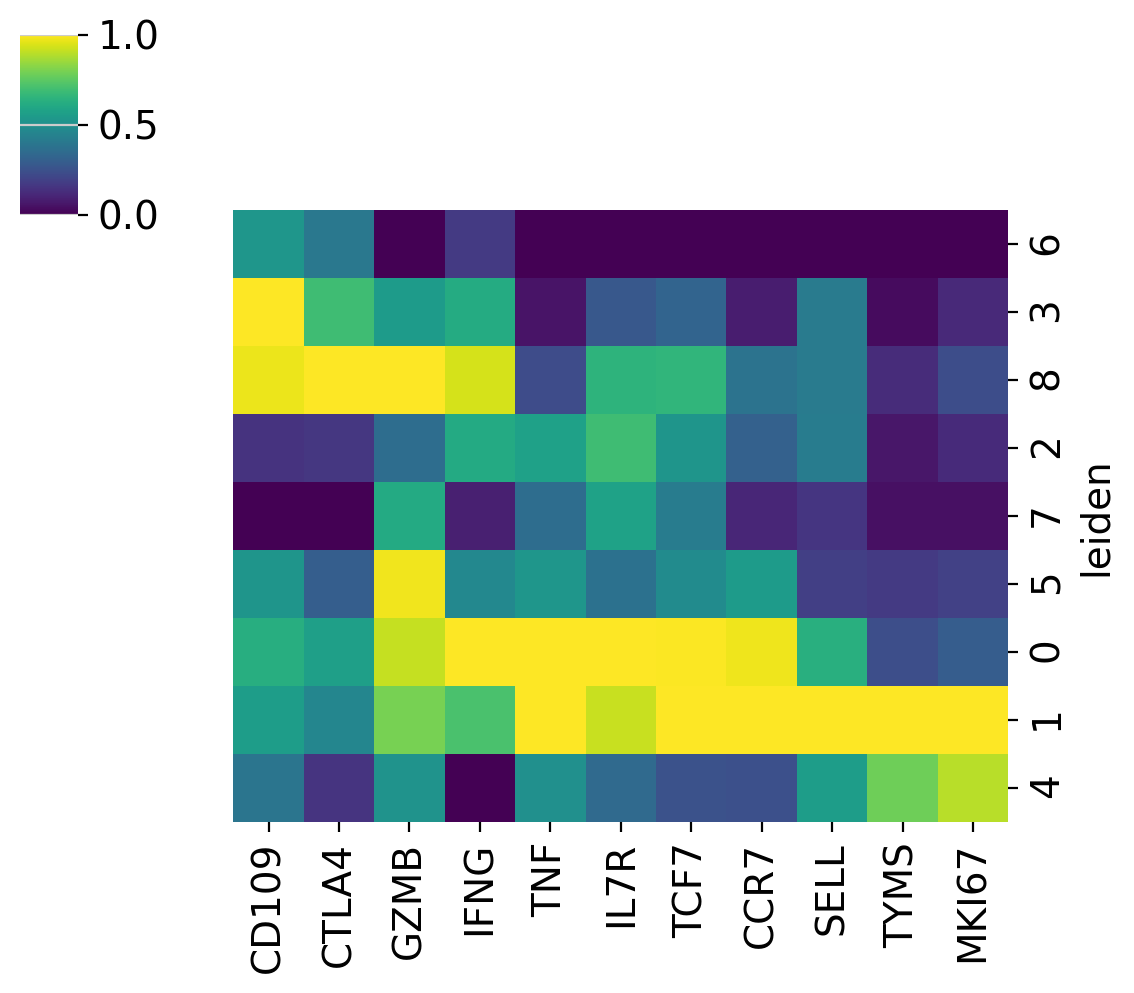

In [631]:
# define the order of phenotypes
rorder = ['Dysfunc. 1','Dysfunc. 2','Dysfunc. 3',
          'Effector 1','Effector 2','Effector 3','Effector 4',
          'Prolif. 1','Prolif. 2']
# define the order of genes
corder = ['CD109','CTLA4','GZMB','IFNG','TNF','IL7R','TCF7','CCR7','SELL','TYMS','MKI67']
# retrieve the gene expression and normalize
gex_df = sc.get.obs_df(adata, keys=corder+['leiden']).groupby('leiden').mean()
# normalize the expressions per gene
gex_df -= gex_df.min(); gex_df /= gex_df.max()
# plot the gene on the heatmap
g = sns.clustermap(gex_df.loc[rorder, corder], cmap='viridis', figsize=[5.8, 5],
                   row_cluster=False, col_cluster=False)
g.ax_heatmap.grid(False)

## Figure 1e

In [ ]:
# retrieve barcode information for each phenotype
df = adata.obs.loc[adata.obs['batch'] == 'D0', ['barcode','phenotype_fine']].dropna().astype(str)
df = df.loc[df['barcode'] != 'AMBIGUOUS']
df['count'] = 1
df = df.pivot_table(index='phenotype_fine', columns='barcode', values='count', aggfunc=np.sum).fillna(0)
# derive pairwise sharing at day 0
df_s = pd.DataFrame(index=df.index, columns=df.index)
for c1 in df_s.index:
    for c2 in df_s.columns:
        mask = (df.loc[[c1, c2]].T > 0).all(1)
        df_s.loc[c1, c2] = df.loc[c1, mask].sum() / df.loc[c1].sum()
# create custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ['#A66A24','#A66A24','#FFD589','#6CE139','#6CE139']
cmap = LinearSegmentedColormap.from_list('', colors)
# plot barcoe sharing data
g = sns.clustermap(df_s.astype(float), cmap='YlGnBu_r', vmin=0.25, vmax=0.75, dendrogram_ratio=.1,
                   figsize=[4, 4], method='ward', cbar_pos=(0, 1, .01, .12))
g.ax_heatmap.grid(False)

## Figure 1g

In [ ]:
# derive the broad phenotype families
adata.obs['phenotype_coarse'] = adata.obs['phenotype_fine'].str.split(' ', expand=True).iloc[:, 0]
# compute the differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby='phenotype_coarse', method='wilcoxon', n_genes=adata.shape[1], use_raw=False)
# derive scores from the top 100 differentially upregulated genes
genes1 = pd.DataFrame(adata.uns['rank_genes_groups']['names'])['Dysfunc.'][:100]
genes2 = pd.DataFrame(adata.uns['rank_genes_groups']['names'])['Prolif.'][:100]
genes3 = pd.DataFrame(adata.uns['rank_genes_groups']['names'])['Effector'][:100]
sc.tl.score_genes(adata, gene_list=genes1, score_name='score_dysfunc', use_raw=False, random_state=0)
sc.tl.score_genes(adata, gene_list=genes2, score_name='score_prolif', use_raw=False, random_state=0)
sc.tl.score_genes(adata, gene_list=genes3, score_name='score_effector', use_raw=False, random_state=0)

# retrieve and normalize the scores
scores = adata.obs[['score_prolif','score_dysfunc','score_effector']].copy()
scores -= np.percentile(scores, 1, axis=0)
scores /= np.percentile(scores, 99, axis=0)
scores[scores < 0] = 0
scores[scores > 1] = 1
# now get the total magnitude
magnitudes = scores.sum(1)
# now get the directions
directions = (scores.T / magnitudes).T

# determine the anchor points
point1 = (0, 1)
point2 = (-0.5, 0)
point3 = (0.5, 0)
points = pd.DataFrame([point1, point2, point3]).values
positions = directions.values @ points
# create a palette
pal = {cat:adata.uns['phenotype_coarse_colors'][idx] for idx, cat in enumerate(adata.obs['phenotype_coarse'].cat.categories)}
color = adata.obs['phenotype_coarse'].map(pal)
# plot the triangle
fig, ax = plt.subplots(figsize=[6, 6])
ax.grid(False)
ax.scatter(positions[:, 0], positions[:, 1], s=5, color=color)
ax.plot([-0.5, 0.5, 0, -0.5], [0, 0, 1, 0], color='k', lw=4)

# derive a MAGIC imputed version of the data
adata_imputed = adata.copy()
sc.external.pp.magic(adata_imputed, random_state=0)
# plot all marker genes with the imputed genes to derive smoother scores rather than sparse expression
# we do this for visualization purposes, all statistics utilize raw or log-library-normalized counts
for key in ['CD109','CTLA4','GZMB','IFNG','TNF','IL7R','TCF7','CCR7','SELL','TYMS','MKI67']:
    cs = sc.get.obs_df(adata_imputed, keys=[key], use_raw=False)[key]
    idxs = np.argsort(cs)
    fig, ax = plt.subplots(figsize=[6, 6])
    ax.grid(False)
    ax.scatter(positions[idxs, 0], positions[idxs, 1], s=5, c=cs[idxs])
    ax.plot([-0.5, 0.5, 0, -0.5], [0, 0, 1, 0], color='k', lw=4)
    ax.set_title(key)

## SI Table 1
The top 100 differentially upregulated genes per cluster were submitted to Enrichr for GO biological process enrichment.

In [ ]:
# create the table
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])
pvals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
pvals_adj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
# loop through each cluster
dfs = []
for cluster in names.columns:
    df = pd.concat([names[cluster], scores[cluster], pvals[cluster], pvals_adj[cluster]], axis=1)
    df.columns = ['Gene','U-statistic','P-value','FDR']
    dfs.append(df)
# write it into an excel
# with pd.ExcelWriter('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/tables/SI_Table_1.xlsx') as writer:
#     for idx, df in enumerate(dfs):
#         df.to_excel(writer, sheet_name=names.columns[idx])

## Figure 1h

In [ ]:
# define the pathways to plot
terms = '''Antigen Receptor-Mediated Signaling Pathway (GO:0050851)
T Cell Receptor Signaling Pathway (GO:0050852)
T Cell Activation (GO:0042110)
Interleukin-12-Mediated Signaling Pathway (GO:0035722)
calcineurin-NFAT Signaling Cascade (GO:0033173)
Cellular Defense Response (GO:0006968)
Positive Regulation Of Leukocyte Mediated Cytotoxicity (GO:0001912)
Positive Regulation Of Lymphocyte Migration (GO:2000403)
Positive Regulation Of Type II Interferon Production (GO:0032729)
Inflammatory Response (GO:0006954)
Mitotic Sister Chromatid Segregation (GO:0000070)
Microtubule Cytoskeleton Organization Involved In Mitosis (GO:1902850)
Positive Regulation Of Cell Cycle Process (GO:0090068)
Mitotic Cytokinesis (GO:0000281)
Mitotic Spindle Assembly (GO:0090307)
Mitotic Cell Cycle Phase Transition (GO:0044772)
Mitotic Nuclear Division (GO:0140014)
Mitotic Chromosome Condensation (GO:0007076)
Cell Cycle G2/M Phase Transition (GO:0044839)
Positive Regulation Of Cell Division (GO:0051781)
Chromatin Remodeling (GO:0006338)
Stress Granule Assembly (GO:0034063)
Histone H3-K4 Methylation (GO:0051568)
Heterochromatin Formation (GO:0031507)
DNA Damage Response (GO:0006974)
Positive Regulation Of Cell Death (GO:0010942)
Regulation Of I-kappaB kinase/NF-kappaB Signaling (GO:0043122)
Regulation Of Mitochondrial Membrane Permeability Involved In Apoptotic Process (GO:1902108)
Negative Regulation Of Cellular Biosynthetic Process (GO:0031327)
Cellular Response To Potassium Ion (GO:0035865)'''
terms = terms.split('\n')

# read in the data
df = pd.DataFrame(index=terms, columns=['dysfunc','effector','prolif'])
for col in df.columns:
    fn = f'~/TMP/fig1.{col}.GO_Biological_Process_2023_table.txt'
    tf = pd.read_table(fn, index_col=0).reindex(df.index)['P-value'].fillna(1)
    df[col] = -np.log10(tf)
# derive a custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ['teal','#FFD589']
cmap = LinearSegmentedColormap.from_list('', colors)
# plot the data
g = sns.clustermap(df.astype(float).T, figsize=[10, 3], cmap=cmap, xticklabels=1, vmax=4,
                   dendrogram_ratio=(.05, .1), cbar_pos=(0, 1, .01, .12), row_cluster=True, col_cluster=True)
g.ax_heatmap.grid(False)

## Figure 2a

/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/loc/scratch/52557510/ipykernel_26572/2556111196.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=xys[:, 0], y=xys[:, 1], ax=ax,


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

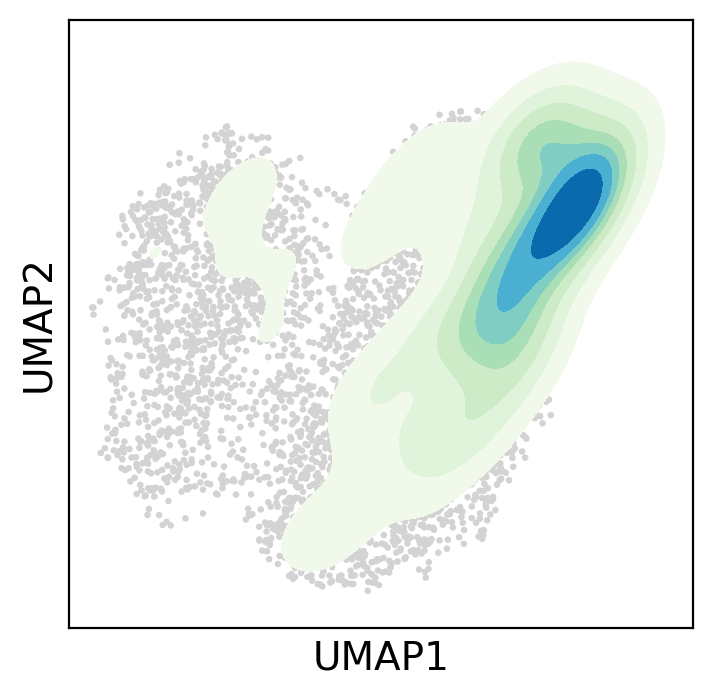

In [687]:
# plot the UMAP base
ax = sc.pl.umap(adata, show=False, na_color='lightgray')
# retrieve the points for day 16
xys = adata.obsm['X_umap'][adata.obs['day'] == 'D16']
# plot the density
sns.kdeplot(x=xys[:, 0], y=xys[:, 1], ax=ax,
            bw_method=1/3, shade=True, cmap='GnBu', levels=8)

## Figure 2b

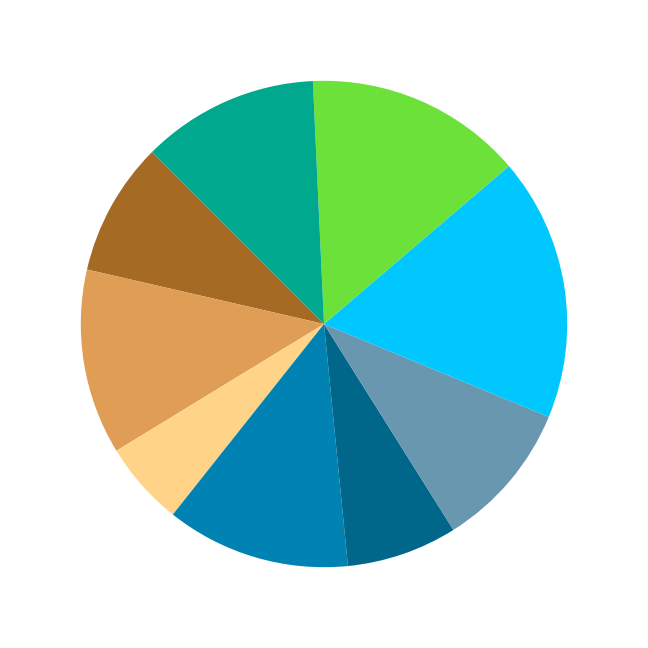

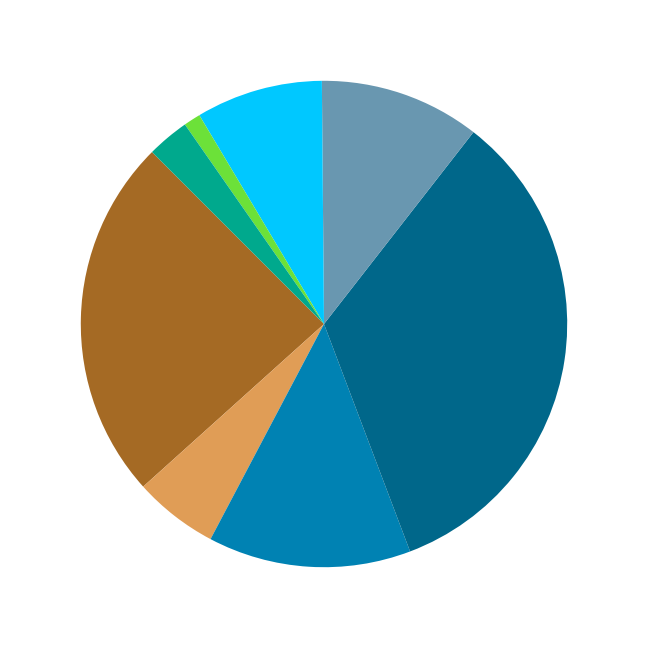

In [691]:
# derive the categories
cats = sorted(adata.obs['phenotype_fine'].cat.categories)
# define the associated colors
colors = ['#00c8ff','#6ce139','#0082b3','#e09d56','#00a98d','#6997b0','#a56a24','#00678a','#ffd489']
colors = [colors[adata.obs['phenotype_fine'].cat.categories.tolist().index(cat)] for cat in cats]
# retrieve the counts
counts_d0 = adata.obs.loc[adata.obs['day'] == 'D0', 'phenotype_fine'].value_counts().loc[cats]
counts_d16 = adata.obs.loc[adata.obs['day'] == 'D16', 'phenotype_fine'].value_counts().loc[cats]
# plot the pie charts
fig, ax = plt.subplots()
_ = ax.pie(counts_d0, colors=colors, startangle=135)
fig, ax = plt.subplots()
_ = ax.pie(counts_d16, colors=colors, startangle=135)

## SI Table 3
Gene rankings were submitted to GSEA. Please see `gsea.R` for code on how GSEA was run and mountain plots derived.

In [778]:
# remove any unexpressed genes
sc.pp.filter_genes(adata, min_cells=1)
# compute the differentially expressed genes
sc.tl.rank_genes_groups(adata, method='wilcoxon', use_raw=False, groupby='day',
                        groups=['D16'], reference='D0', n_genes=adata.shape[1])

# create the table
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])
pvals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
pvals_adj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
# loop through each cluster
dfs = []
for cluster in names.columns:
    df = pd.concat([names[cluster], scores[cluster], pvals[cluster], pvals_adj[cluster]], axis=1)
    df.columns = ['Gene','U-statistic','P-value','FDR']
    dfs.append(df)

# write it into an excel
with pd.ExcelWriter('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/tables/SI_Table_3.xlsx') as writer:
    df.to_excel(writer, sheet_name='D16_vs_D0')

/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## Figure 2c

/loc/scratch/52557510/ipykernel_26572/2181747973.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('GnBu')


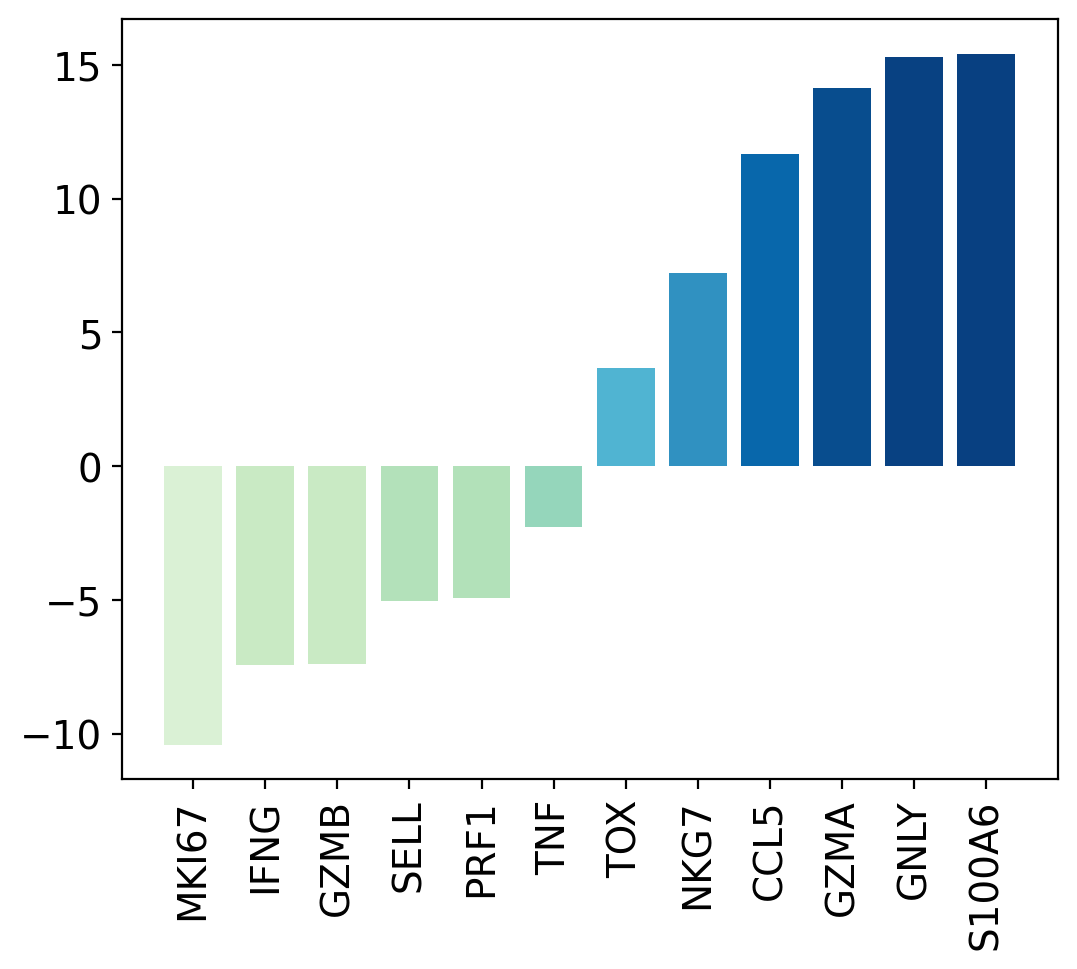

In [782]:
from matplotlib.colors import to_hex
from matplotlib.cm import get_cmap
# colormap is retrieved
cmap = get_cmap('GnBu')
# names and scores are retrieved
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])['D16']
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])['D16']
scores.index = names
# marker genes are chosen adn plotted
genes = ['GZMA','GNLY','CCL5','GZMB','PRF1','TOX','IFNG','TNF','SELL','NKG7','MKI67','S100A6']
data = scores.loc[genes].sort_values()
# colors are derived from normalized data
vmax = abs(data).max()
cs = data + vmax
cs /= 2 * vmax
cs = [to_hex(cmap(c)) for c in cs]
# bar chart is plotted
fig, ax = plt.subplots(figsize=[6, 5])
ax.grid(False)
ax.bar(data.index, data, color=cs)
ax.tick_params(axis='x', labelrotation=90)

## Figure 2d

/loc/scratch/52557510/ipykernel_26572/745499711.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Greens')


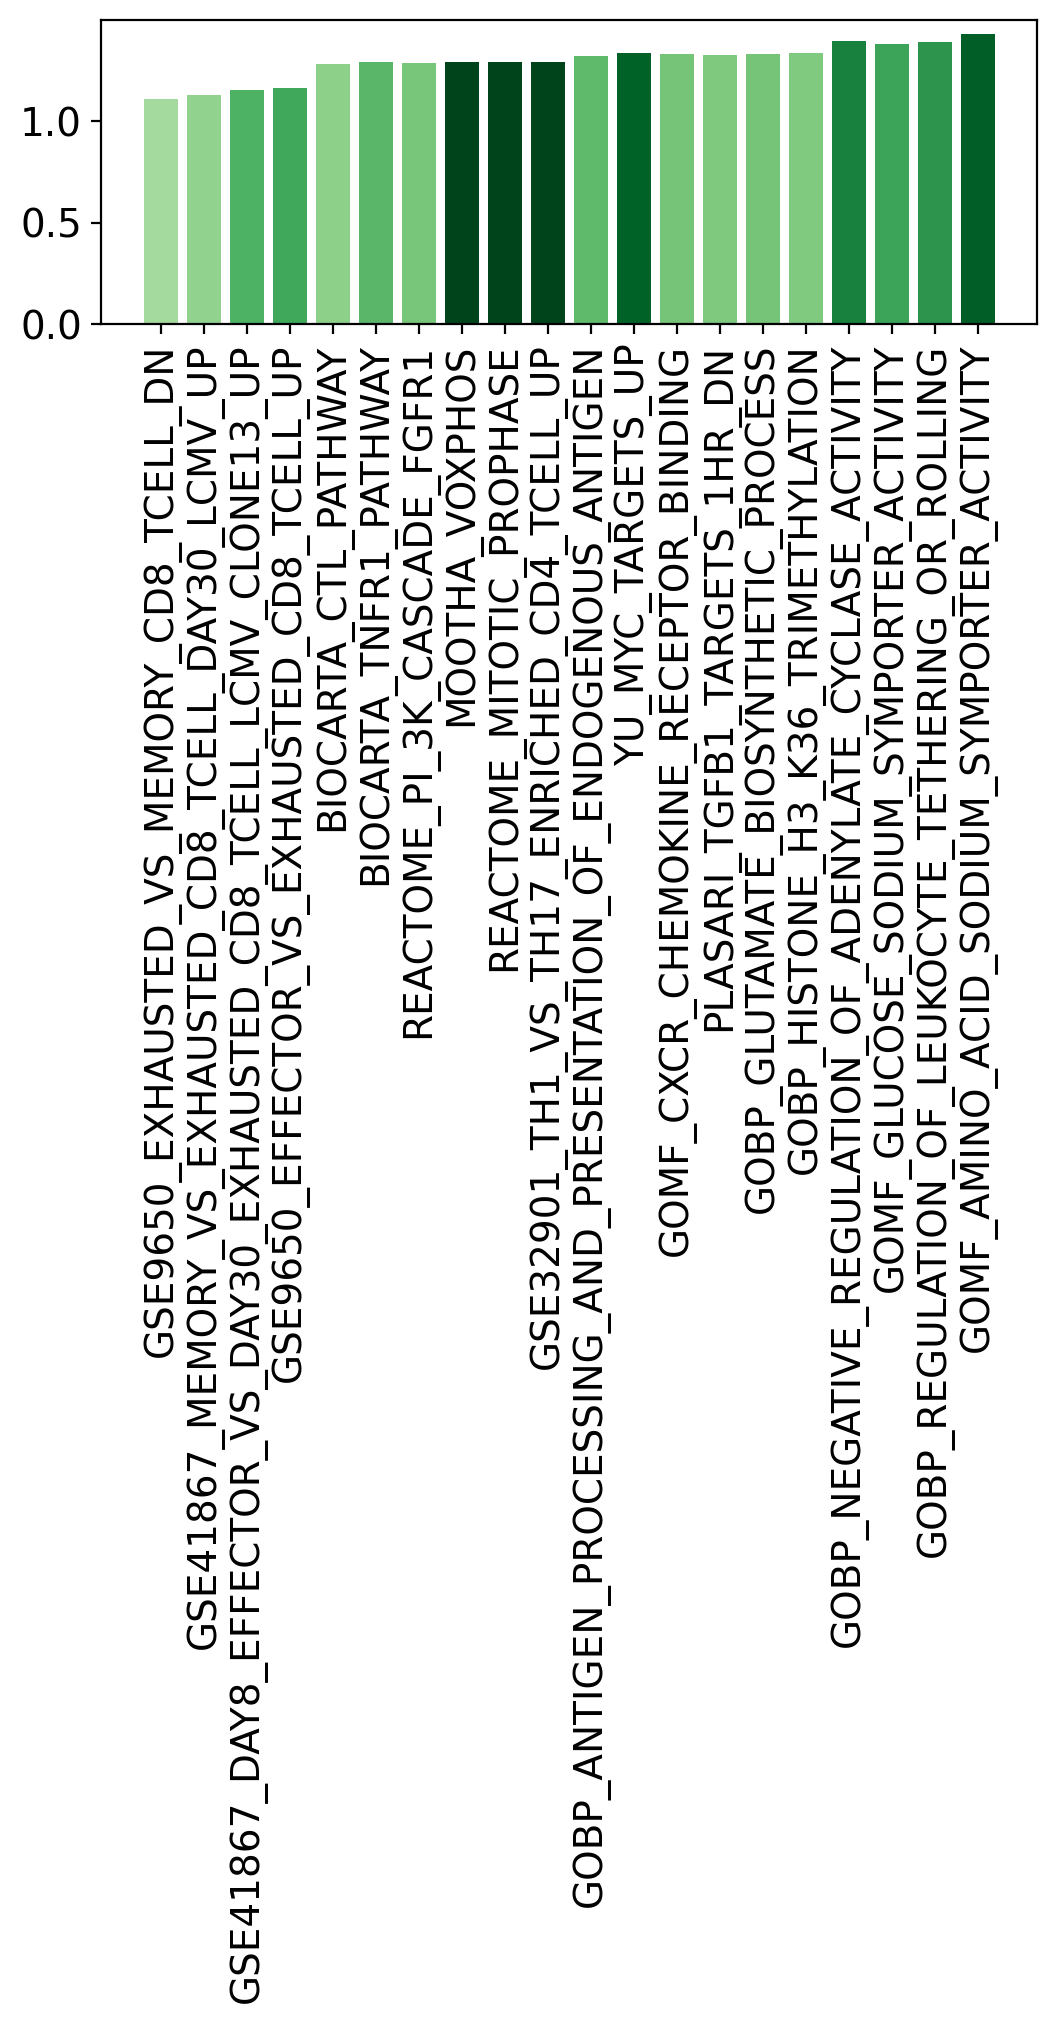

In [810]:
# derive the terms to plot
terms = '''GSE9650_EXHAUSTED_VS_MEMORY_CD8_TCELL_DN
GSE41867_MEMORY_VS_EXHAUSTED_CD8_TCELL_DAY30_LCMV_UP
GSE41867_DAY8_EFFECTOR_VS_DAY30_EXHAUSTED_CD8_TCELL_LCMV_CLONE13_UP
GSE9650_EFFECTOR_VS_EXHAUSTED_CD8_TCELL_UP
BIOCARTA_CTL_PATHWAY
BIOCARTA_TNFR1_PATHWAY
REACTOME_PI_3K_CASCADE_FGFR1
MOOTHA_VOXPHOS
REACTOME_MITOTIC_PROPHASE
GSE32901_TH1_VS_TH17_ENRICHED_CD4_TCELL_UP
GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_ENDOGENOUS_ANTIGEN
YU_MYC_TARGETS_UP
GOMF_CXCR_CHEMOKINE_RECEPTOR_BINDING
PLASARI_TGFB1_TARGETS_1HR_DN
GOBP_GLUTAMATE_BIOSYNTHETIC_PROCESS
GOBP_HISTONE_H3_K36_TRIMETHYLATION
GOBP_NEGATIVE_REGULATION_OF_ADENYLATE_CYCLASE_ACTIVITY
GOMF_GLUCOSE_SODIUM_SYMPORTER_ACTIVITY
GOBP_REGULATION_OF_LEUKOCYTE_TETHERING_OR_ROLLING
GOMF_AMINO_ACID_SODIUM_SYMPORTER_ACTIVITY'''.split('\n')
# read in the data and subset for relevant terms
df = pd.read_csv('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/gsea/d16_vs_d0.gsea.csv', index_col=0)
df = df.loc[terms]
# derive colors from p-values
cmap = get_cmap('Greens')
cs = -np.log10(df['pvalue'])
cs /= 4
cs = [to_hex(cmap(c)) for c in cs]
# plot bar chart based on enrichment score, normalized
fig, ax = plt.subplots(figsize=[6, 2])
ax.grid(False)
ax.bar(df.index, -df['NES'], color=cs)
ax.tick_params(axis='x', labelrotation=90)

## Figure 2e

/loc/scratch/52557510/ipykernel_26572/1202422432.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[(adata.obs['batch'] == 'D0') & (adata.obs['barcode'].isin(barcodes)), 'persisted'] = 'True'
/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


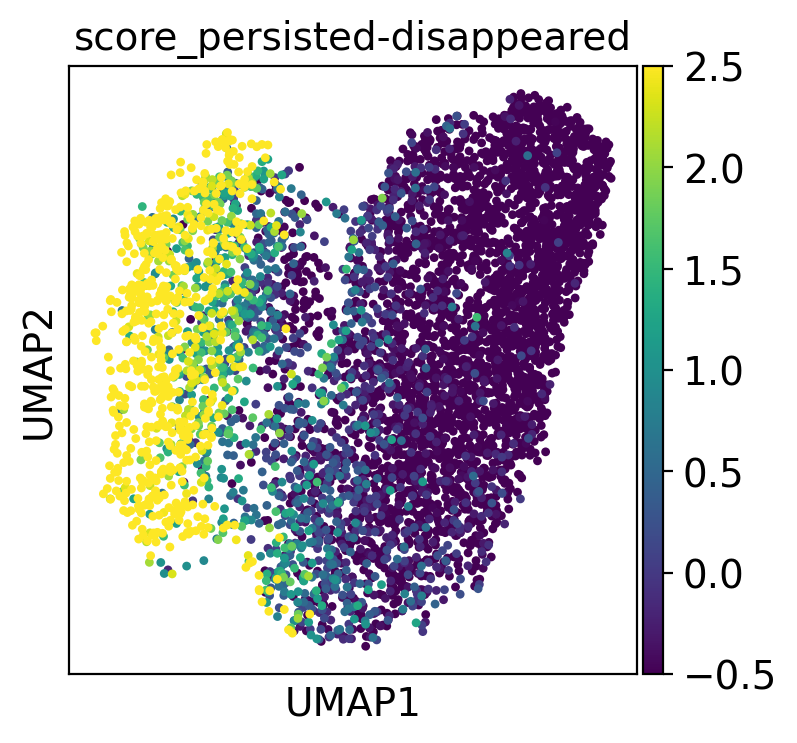

In [811]:
# derive non-ambiguous post-co-culture barcodes
barcodes = a.obs.loc[a.obs['batch'] != 'D0', 'barcode'].dropna().unique()
barcodes = barcodes[barcodes != 'AMBIGUOUS']
# derive persistence specific differentially expressed genes, DEGs
adata.obs['persisted'] = np.nan
adata.obs.loc[(adata.obs['batch'] == 'D0') & (adata.obs['barcode'].isin(barcodes)), 'persisted'] = 'True'
adata.obs.loc[(adata.obs['batch'] == 'D0') & (~adata.obs['barcode'].isin(barcodes)), 'persisted'] = 'False'
sc.tl.rank_genes_groups(adata, groupby='persisted', method='wilcoxon', n_genes=8000,
                        use_raw=False, groups=['True'], reference='False', random_state=0)
# derive the gene signatures
sc.tl.score_genes(adata, gene_list=pd.DataFrame(adata.uns['rank_genes_groups']['names'])['True'][:100].tolist(),
                  random_state=0, score_name='score_persisted')
sc.tl.score_genes(adata, gene_list=pd.DataFrame(adata.uns['rank_genes_groups']['names'])['True'][-100:].tolist(),
                  random_state=0, score_name='score_disappeared')
# normalize the two scores to derive a cohesisve persistence score
adata.obs[['score_persisted','score_disappeared']] -= adata.obs[['score_persisted','score_disappeared']].mean()
adata.obs[['score_persisted','score_disappeared']] /= adata.obs[['score_persisted','score_disappeared']].std()
adata.obs['score_persisted-disappeared'] = adata.obs['score_persisted'] - adata.obs['score_disappeared']
sc.pl.umap(adata, color=['score_persisted-disappeared'], cmap='viridis', vmin=-0.5, vmax=2.5, s=40)

## Figure 2f

/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


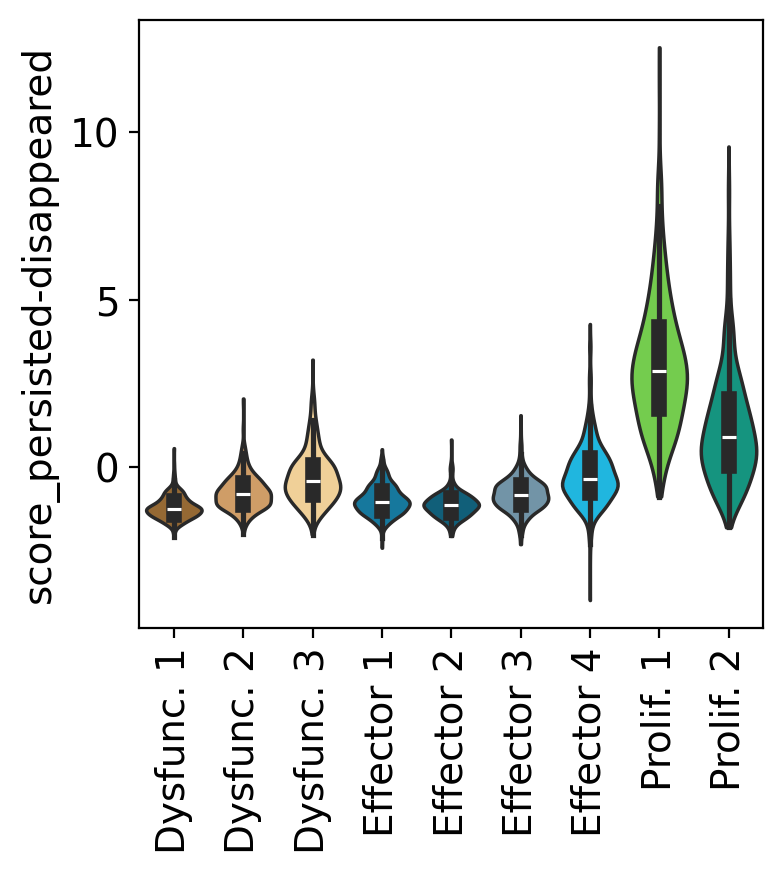

Maximum p-value is 1.1955318423570309e-73


In [812]:
# derive the order and colors of phenotypes
order = sorted(adata.obs['phenotype_fine'].cat.categories)
adata.uns['phenotype_fine_colors'] = ['#00c8ff','#6ce139','#0082b3','#e09d56','#00a98d','#6997b0','#a56a24','#00678a','#ffd489']
# plot the violin plots
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
sc.pl.violin(adata[adata.obs['day'] == 'D0'], groupby='phenotype_fine', rotation=90,
             keys=['score_persisted-disappeared'], order=order, inner='box', ax=ax, stripplot=False)
# derive the p-values
ps = []
for x in order:
    if x == 'Prolif. 1': continue
    x1 = a.obs.loc[(a.obs['day'] == 'D0')&(a.obs['phenotype_fine'] == x), 'score_persisted-disappeared']
    x2 = a.obs.loc[(a.obs['day'] == 'D0')&(a.obs['phenotype_fine'] == 'Prolif. 1'), 'score_persisted-disappeared']
    ps.append(ss.mannwhitneyu(x1, x2)[1])
print('Maximum p-value is', max(ps))

## SI Table 5
Gene rankings were submitted to GSEA.

In [813]:
# create the table
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])
pvals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
pvals_adj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
# loop through each cluster
dfs = []
for cluster in names.columns:
    df = pd.concat([names[cluster], scores[cluster], pvals[cluster], pvals_adj[cluster]], axis=1)
    df.columns = ['Gene','U-statistic','P-value','FDR']
    dfs.append(df)
# write it into an excel
with pd.ExcelWriter('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/tables/SI_Table_5.xlsx') as writer:
    df.to_excel(writer, sheet_name='Persisted_vs_Rest')

## Figure 2h

/loc/scratch/52557510/ipykernel_26572/1824113127.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Lnon1or4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[(adata.obs['batch'] == 'D0') & (adata.obs['barcode'].isin(barcodes_lnon14)), 'd16_fate'] = 'Lnon1or4'
/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


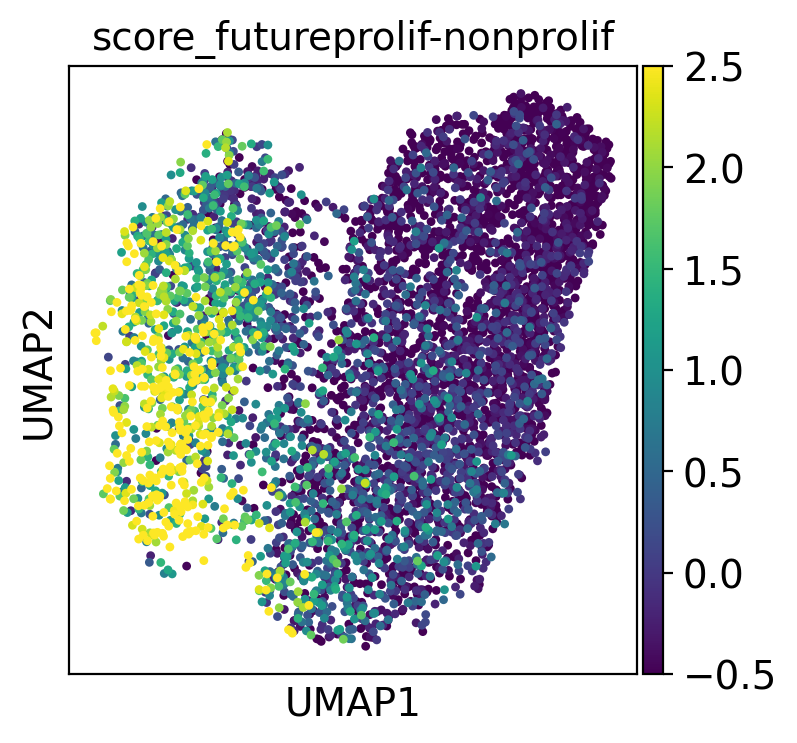

In [817]:
# only forty barcodes for forty-seven cells
barcodes_l14 = np.intersect1d(barcodes, adata.obs.loc[adata.obs['leiden'].isin(['1','4']), 'barcode'].dropna().unique())
barcodes_lnon14 = np.intersect1d(barcodes, adata.obs.loc[~adata.obs['leiden'].isin(['1','4']), 'barcode'].dropna().unique())
# remove the shared barcodes that are also ambiguous
shared = np.intersect1d(barcodes_l14, barcodes_lnon14)
barcodes_lnon14 = [x for x in barcodes_lnon14 if x not in shared]
barcodes_l14 = [x for x in barcodes_l14 if x not in shared]
# compare the persisting versus non-persisting group
adata.obs['d16_fate'] = np.nan
adata.obs.loc[(adata.obs['batch'] == 'D0') & (adata.obs['barcode'].isin(barcodes_lnon14)), 'd16_fate'] = 'Lnon1or4'
adata.obs.loc[(adata.obs['batch'] == 'D0') & (adata.obs['barcode'].isin(barcodes_l14)), 'd16_fate'] = 'L1or4'
sc.tl.rank_genes_groups(adata, groupby='d16_fate', method='wilcoxon', n_genes=8000,
                        use_raw=False, groups=['L1or4'], reference='Lnon1or4', random_state=0)
# derive a score
sc.tl.score_genes(adata, gene_list=pd.DataFrame(adata.uns['rank_genes_groups']['names'])['L1or4'][:100].tolist(),
                  random_state=0, score_name='score_futureprolif')
sc.tl.score_genes(adata, gene_list=pd.DataFrame(adata.uns['rank_genes_groups']['names'])['L1or4'][-100:].tolist(),
                  random_state=0, score_name='score_nonprolif')
# normalize the two scores to derive a cohesisve future proliferator score
adata.obs[['score_futureprolif','score_nonprolif']] -= adata.obs[['score_futureprolif','score_nonprolif']].mean()
adata.obs[['score_futureprolif','score_nonprolif']] /= adata.obs[['score_futureprolif','score_nonprolif']].std()
adata.obs['score_futureprolif-nonprolif'] = adata.obs['score_futureprolif'] - adata.obs['score_nonprolif']
sc.pl.umap(adata, color=['score_futureprolif-nonprolif'], cmap='viridis', vmin=-0.5, vmax=2.5, s=40)

## Figure 2i

/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/dchen2/anaconda3/envs/base_py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


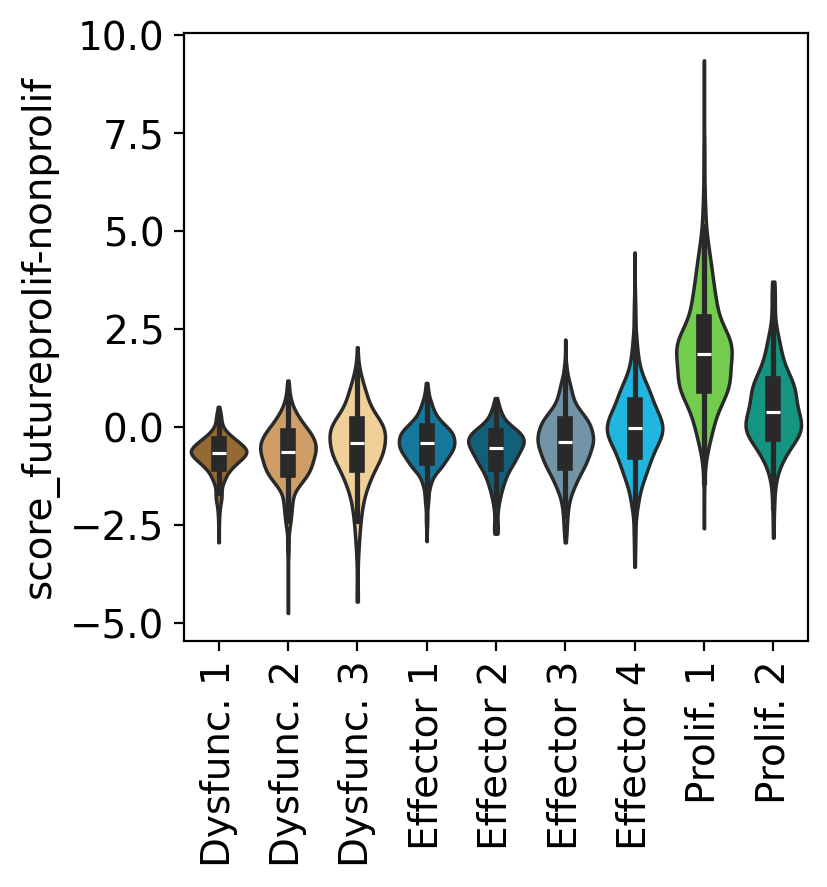

Maximum p-value is 9.041407159639361e-86


In [818]:
# derive the order and colors of phenotypes
order = sorted(adata.obs['phenotype_fine'].cat.categories)
adata.uns['phenotype_fine_colors'] = ['#00c8ff','#6ce139','#0082b3','#e09d56','#00a98d','#6997b0','#a56a24','#00678a','#ffd489']
# plot the violin plots
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
sc.pl.violin(adata[adata.obs['day'] == 'D0'], groupby='phenotype_fine', rotation=90,
             keys=['score_futureprolif-nonprolif'], order=order, inner='box', ax=ax, stripplot=False)
# derive the p-values
ps = []
for x in order:
    if x == 'Prolif. 1': continue
    x1 = a.obs.loc[(a.obs['day'] == 'D0')&(a.obs['phenotype_fine'] == x), 'score_futureprolif-nonprolif']
    x2 = a.obs.loc[(a.obs['day'] == 'D0')&(a.obs['phenotype_fine'] == 'Prolif. 1'), 'score_futureprolif-nonprolif']
    ps.append(ss.mannwhitneyu(x1, x2)[1])
print('Maximum p-value is', max(ps))

## SI Table 7
Gene rankings were submitted to GSEA.

In [819]:
# create the table
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'])
pvals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
pvals_adj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
# loop through each cluster
dfs = []
for cluster in names.columns:
    df = pd.concat([names[cluster], scores[cluster], pvals[cluster], pvals_adj[cluster]], axis=1)
    df.columns = ['Gene','U-statistic','P-value','FDR']
    dfs.append(df)
# write it into an excel
with pd.ExcelWriter('/fh/fast/greenberg_p/user/dchen2/LINEAGE_TRACING/tables/SI_Table_7.xlsx') as writer:
    df.to_excel(writer, sheet_name='Future-proliferator_vs_Rest')

## Figure 2k

PearsonRResult(statistic=0.6837237719373165, pvalue=0.0)

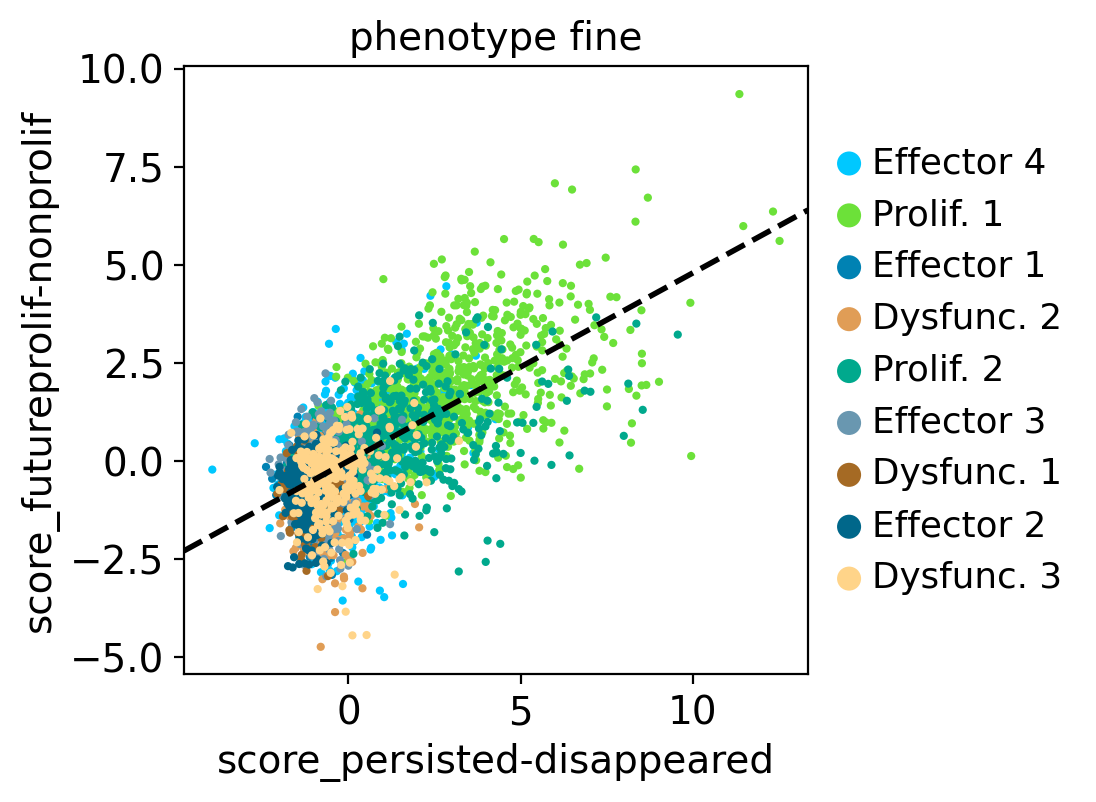

In [809]:
# setup the figure axis
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# plot the dots
ax = sc.pl.scatter(a, x='score_persisted-disappeared', y='score_futureprolif-nonprolif', color='phenotype_fine', ax=ax, size=35, show=False)
# derive the linear approximation
model = np.polynomial.Polynomial(0)
model = model.fit(a.obs['score_persisted-disappeared'], a.obs['score_futureprolif-nonprolif'], 1)
xlim = ax.get_xlim()
xl, yl = model.linspace(domain=xlim)
# plot the linear approximation
ax.plot(xl, yl, color='k', linestyle='--', lw=2)
ax.set_xlim(*xlim)
# report on the statistics of correlation
ss.pearsonr(a.obs['score_persisted-disappeared'], a.obs['score_futureprolif-nonprolif'])